## Experiment to determine Frequency for running Model 

Author : Sai Siddartha Maram


Contact: msaisiddartha1@gmail.com | smaram_be16@thapar.edu

### Objectives
1. Run detection at Camera FPS, in our case the camera FPS is 30FPS, to start of I will run detection on every 30th image.
2. Log all the bounding boxes and classes of objects detected
3. Develop a certain metric in terms of centers of bounding boxes, classes detected to determine if the two scenes are different
4. Try delta methods and see if they match


In [49]:
import cv2
import numpy as np
import argparse
import time
import cv2
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imutils

from scipy.spatial import distance as dist
import numpy as np

from skimage.measure import compare_ssim
from PIL import Image
import time

import scipy
import random

import imagehash
# My Packages
import constants
import helper


Loading Model : YOLOV3

In [2]:
options = constants.options_v3
np.random.seed(42)
LABELS = open(options['labelsPath']).read().strip().split("\n")
color = (255, 0, 0)

1. Load the darknet model using readNetFromDarkent(), feel free to try other DL models
2.  In CV2.dnn you load a model and then forward propgate the image for prediction, 
    the forwad function expects you give the layer till which you want the image to be 
    propgated, in our case since we want the final result, we want the image to be 
    propgated till the last layer. The .getLayerNames() gives the list of all layers.
    From here to identify the last layer, we need to get last unconnected layer, the 
    unconnected layers can be found by .getUnconnectedOutLayers().
3. blob, the cv.dnn does not take a raw image, instead takes a blob, A blob is an image which 
   is modified and smoothed as per the network requirments. For Ex. 
   YOLO takes in an image only of the size 416 x 416 (single channel)
   hence we reduce each color from [0-255] to [0-1] and image size (416,416)

In [29]:
def predict_object(image_path,net):
    start = time.time()
    image = cv2.imread(image_path)
    #image=cv2.resize(image,(416,416))
    (H, W) = image.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(
        image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    
    layerOutputs = net.forward(ln)
    

    # show timing information on YOLO
    

    boxes = []
    confidences = []
    classIDs = []
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > options['confidence']:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, options['confidence'], options['threshold'])
    
    detections=[]
    if len(idxs) > 0:
        for i in idxs.flatten():
            temp_list=[]
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 3)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5),cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            plt.imshow(image)

            temp_list.append(x)
            temp_list.append(y)
            temp_list.append(w)
            temp_list.append(h)
            temp_list.append(LABELS[classIDs[i]])
            temp_list.append(confidences[i])
            detections.append(temp_list)
            
    print('Time Taken', time.time()-start)   
    return detections

In [30]:
def predict_image(image,net):
    start = time.time()
    #image = cv2.imread(image_path)
    #image=cv2.resize(image,(416,416))
    (H, W) = image.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(
        image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    
    layerOutputs = net.forward(ln)
    

    # show timing information on YOLO
    

    boxes = []
    confidences = []
    classIDs = []
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > options['confidence']:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, options['confidence'], options['threshold'])
    
    detections=[]
    if len(idxs) > 0:
        for i in idxs.flatten():
            temp_list=[]
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 3)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5),cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            plt.imshow(image)

            temp_list.append(x)
            temp_list.append(y)
            temp_list.append(w)
            temp_list.append(h)
            temp_list.append(LABELS[classIDs[i]])
            temp_list.append(confidences[i])
            detections.append(temp_list)
            
    print('Time Taken', time.time()-start)   
    return detections

    


  

    


In [31]:
net = cv2.dnn.readNetFromDarknet(options['model'], options['load'])

Time Taken 1.0346488952636719
Number of Detections: 4
[363, 692, 57, 246, 'person', 0.8407601714134216]
[1559, 87, 86, 92, 'car', 0.7853524684906006]
[360, 702, 56, 154, 'person', 0.6280760765075684]
[498, 752, 70, 208, 'person', 0.548801839351654]


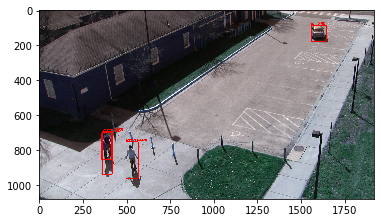

In [32]:
detections=predict_object('testing_images/4561.jpg',net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')


Time Taken 0.992938756942749
Number of Detections: 7
[1168, 444, 311, 161, 'car', 0.9971790313720703]
[1238, 335, 44, 110, 'person', 0.9966909289360046]
[1664, 357, 40, 96, 'person', 0.986341655254364]
[1613, 386, 47, 116, 'person', 0.9570065140724182]
[1712, 387, 39, 88, 'person', 0.8744476437568665]
[1373, 69, 43, 80, 'person', 0.7361916303634644]
[1373, 72, 27, 50, 'person', 0.6172140836715698]


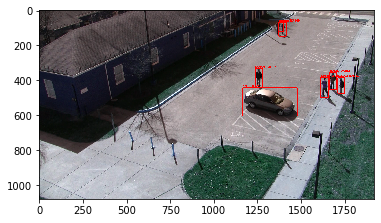

In [33]:
detections=predict_object('testing_images/16892.jpg',net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')


In [34]:
def image_subtraction(path_image1,path_image2):
    img1 = cv2.imread(path_image1)
    img2 = cv2.imread(path_image2)


    start_time=time.time()
    grayA = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    (score, grad,diff) = compare_ssim(grayA, grayB, full=True,gradient=True)
    #value ranges between -1 to 1. 1 indicates a perfect match
    print('Time Taken for execution',time.time()-start_time)
    print("SSIM: {}".format(score))
    


In [35]:
image_subtraction('testing_images/4561.jpg','testing_images/16892.jpg')

Time Taken for execution 0.46047472953796387
SSIM: 0.837833208292906


In [36]:
def histogram_matching(path_image1, path_image2):
    img1 = cv2.imread(path_image1)
    img2 = cv2.imread(path_image2)
#     plt.hist(img1.ravel(),256,[0,256])
#     plt.show()
#     plt.hist(img2.ravel(),256,[0,256])
#     plt.show()

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    start_time=time.time()

    hist1 = cv2.calcHist(img1, [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist1 = cv2.normalize(hist1, hist1).flatten()

    hist2 = cv2.calcHist(img2, [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist2 = cv2.normalize(hist2, hist2).flatten()

    #a = cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT) ----> WASTE!
    #a = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL) ----->Waste!
    chi_square = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    print('[INFO]Time for Histogram Mapping',time.time()-start_time)

    return chi_square


In [37]:
chi=histogram_matching('testing_images/4561.jpg','testing_images/4561.jpg')
print('CHI Square value',chi)

[INFO]Time for Histogram Mapping 0.001018524169921875
CHI Square value 0.0


In [38]:
chi=histogram_matching('testing_images/4561.jpg','testing_images/16892.jpg')
print('CHI Square value',chi)

[INFO]Time for Histogram Mapping 0.001001596450805664
CHI Square value 0.07969235225853039


In [39]:
chi=histogram_matching('testing_images/4561.jpg','testing_images/2.jpg')
print('CHI Square value',chi)

[INFO]Time for Histogram Mapping 0.0010230541229248047
CHI Square value 0.16284510427246612


### Learnable Encryption

In [116]:
img=cv2.imread('testing_images/16892.jpg')
print(img.shape)

(1080, 1920, 3)


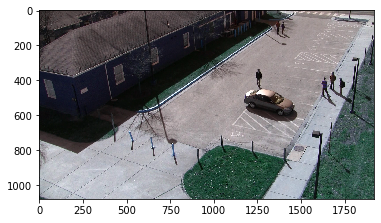

In [117]:
N=8
M=8
plt.imshow(img)

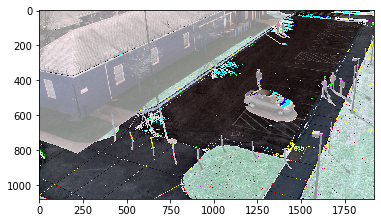

In [118]:
# b=[]
# for x in range(0,img.shape[0],M):
#     for y in range(0,img.shape[1],N):
#         b.append(img[x:x+M,y:y+N])
# print(len(b))

blank_image = np. zeros(shape=[1080,1920, 3], dtype=np. uint8)

for x in range(0,img.shape[0],M):
    for y in range(0,img.shape[1],N):
        blank_image[x:x+M,y:y+N]=img[x:x+M,y:y+N]+129

cv2.imshow('img',blank_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(blank_image)

Time Taken 0.4727439880371094
Number of Detections: 1
[1174, 457, 298, 177, 'car', 0.8104709386825562]


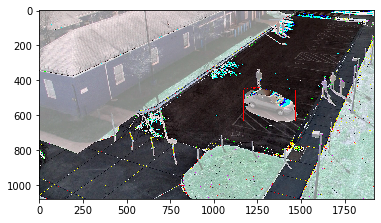

In [119]:
detections=predict_image(blank_image,net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')


### Look up table for color mapping

In [120]:

def look_up_table_mapping(im_gray) :
    
    lut = np.zeros((256, 1, 3), dtype=np.uint8)
    lut[:, 0, 0] = [255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,253,251,249,247,245,242,241,238,237,235,233,231,229,227,225,223,221,219,217,215,213,211,209,207,205,203,201,199,197,195,193,191,189,187,185,183,181,179,177,175,173,171,169,167,165,163,161,159,157,155,153,151,149,147,145,143,141,138,136,134,132,131,129,126,125,122,121,118,116,115,113,111,109,107,105,102,100,98,97,94,93,91,89,87,84,83,81,79,77,75,73,70,68,66,64,63,61,59,57,54,52,51,49,47,44,42,40,39,37,34,33,31,29,27,25,22,20,18,17,14,13,11,9,6,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    lut[:, 0, 1] = [255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,254,252,250,248,246,244,242,240,238,236,234,232,230,228,226,224,222,220,218,216,214,212,210,208,206,204,202,200,198,196,194,192,190,188,186,184,182,180,178,176,174,171,169,167,165,163,161,159,157,155,153,151,149,147,145,143,141,139,137,135,133,131,129,127,125,123,121,119,117,115,113,111,109,107,105,103,101,99,97,95,93,91,89,87,85,83,82,80,78,76,74,72,70,68,66,64,62,60,58,56,54,52,50,48,46,44,42,40,38,36,34,32,30,28,26,24,22,20,18,16,14,12,10,8,6,4,2,0 ]
    lut[:, 0, 2] = [195,194,193,191,190,189,188,187,186,185,184,183,182,181,179,178,177,176,175,174,173,172,171,170,169,167,166,165,164,163,162,161,160,159,158,157,155,154,153,152,151,150,149,148,147,146,145,143,142,141,140,139,138,137,136,135,134,133,131,130,129,128,127,126,125,125,125,125,125,125,125,125,125,125,125,125,125,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126,126]
    
    
    print('image')
    print(im_gray[0][0])

    print('Look Up Table')
    print(lut[:, 0, 0][50])
    print(lut[:, 0, 1][58])
    print(lut[:, 0, 2][57])
    
    im_color = cv2.LUT(im_gray, lut)
    print('im_color')
    print(im_color[0][0])
    return im_color;

In [121]:
im = cv2.imread('testing_images/sample_dog.jpg' )
im_color = look_up_table_mapping(im)

cv2.imshow('encoded',im_color)
cv2.waitKey(0)
cv2.destroyAllWindows()

image
[50 58 57]
Look Up Table
255
255
133
im_color
[255 255 133]


Time Taken 0.6395480632781982
Number of Detections: 3
[123, 222, 196, 321, 'dog', 0.997923731803894]
[117, 124, 451, 308, 'bicycle', 0.9899414777755737]
[473, 86, 218, 80, 'truck', 0.9365639686584473]


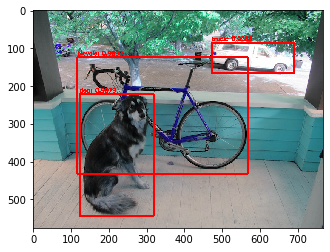

In [122]:
detections=predict_object('testing_images/sample_dog.jpg',net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')

Time Taken 0.45538878440856934
Number of Detections: 2
[109, 151, 465, 267, 'bicycle', 0.9992066025733948]
[470, 76, 233, 97, 'car', 0.8836500644683838]


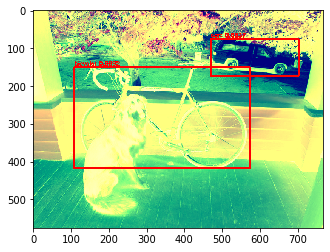

In [47]:
detections=predict_image(im_color,net)
print('Number of Detections:', len(detections))
print(*detections,sep='\n')


# detections=predict_object('testing_images/4561.jpg',net)
# print('Number of Detections:', len(detections))
# print(*detections,sep='\n')
